In [7]:
import requests
import json
import pandas as pd
import datetime

# Import climate data & covert to dataframe
initial_date = datetime.datetime(2022, 2, 6, 23)
response = requests.get(f"https://climatedataapi.azurewebsites.net/api/data?startdate={initial_date.isoformat()}")
df_raw = pd.DataFrame(json.loads(response.content.decode("utf-8")))

# Clean up dataframe
df_raw.rename(columns={"rm":"Room", "ti":"Date", "te":"Temperature_C", "hu":"Humidity"}, inplace=True)
df_raw["Date"] = pd.to_datetime(df_raw["Date"])
df_raw["Temperature_F"] = df_raw["Temperature_C"] * 9/5 + 32

# Create pivot table
df_pivot = df_raw.pivot(index="Date", columns="Room", values=["Temperature_F", "Humidity"])
display(df_pivot)

# Resample data from hourly to daily
df_pivot = df_pivot.resample("D").mean()

# Compile daily overall averages
temp_avg = df_pivot["Temperature_F"].agg("mean", "columns")
humidity_avg = df_pivot["Humidity"].agg("mean", "columns")

Temperature_F                          Humidity        \
Room                       Darrin Logan Lyndi Master  Ryan   Darrin Logan   
Date                                                                        
2022-02-06 23:00:00          77.0  77.0  69.8   75.2  77.0     26.0  24.0   
2022-02-07 00:00:00          77.0  77.0  69.8   75.2  77.0     26.0  24.0   
2022-02-07 01:00:00          77.0  77.0  69.8   75.2  77.0     25.0  24.0   
2022-02-07 02:00:00          75.2  77.0  68.0   75.2  77.0     24.0  24.0   
2022-02-07 03:00:00          75.2  75.2  68.0   73.4  77.0     23.0  22.0   
...                           ...   ...   ...    ...   ...      ...   ...   
2022-05-23 21:00:00          69.8  75.2  69.8   73.4  69.8     37.0  26.0   
2022-05-23 22:00:00          68.0  75.2  69.8   71.6  69.8     35.0  26.0   
2022-05-23 23:00:00          71.6  75.2  71.6   71.6  73.4     36.0  26.0   
2022-05-24 00:00:00          71.6  75.2  69.8   71.6  73.4     32.0  26.0   
2022-05-24 01:00:00          71.6  75.2  71.6   71.6  73.4     32.0  26.0   

                                        
Room                Lyndi Master  Ryan  
Date                                    
2022-02-06 23:00:00  33.0   26.0  21.0  
2022-02-07 00:00:00  33.0   26.0  21.0  
2022-02-07 01:00:00  34.0   26.0  20.0  
2022-02-07 02:00:00  33.0   25.0  20.0  
2022-02-07 03:00:00  32.0   25.0  19.0  
...                   ...    ...   ...  
2022-05-23 21:00:00  42.0   30.0  40.0  
2022-05-23 22:00:00  40.0   30.0  36.0  
2022-05-23 23:00:00  39.0   31.0  37.0  
2022-05-24 00:00:00  40.0   31.0  33.0  
2022-05-24 01:00:00  40.0   31.0  30.0  

[2547 rows x 10 columns]

In [8]:
# Import local weather data into a dataframe
df_weather_data = pd.read_csv(f"https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023183&startDate={initial_date.isoformat()}Z&endDate={datetime.datetime.now().isoformat()}Z&dataTypes=TAVG&format=csv&units=standard")

# Clean up dataframe
df_weather_data.rename(columns={"DATE":"Date", "TAVG":"AvgTemp"}, inplace=True)
df_weather_data["Date"] = pd.to_datetime(df_weather_data["Date"])

# Display dataframe
df_weather_data[["Date","AvgTemp"]]

,Date,AvgTemp
0,2022-02-06,54
1,2022-02-07,63
2,2022-02-08,59
3,2022-02-09,63
4,2022-02-10,66
...,...,...
97,2022-05-14,85
98,2022-05-15,89
99,2022-05-16,91
100,2022-05-17,89


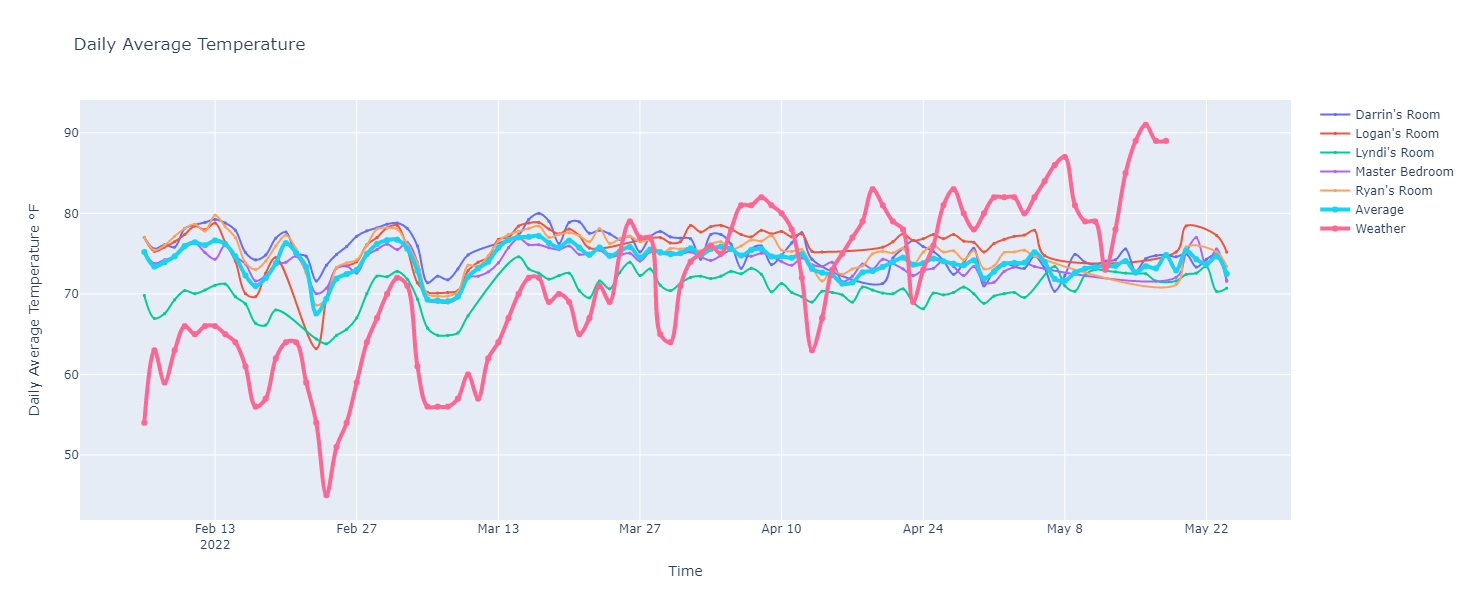

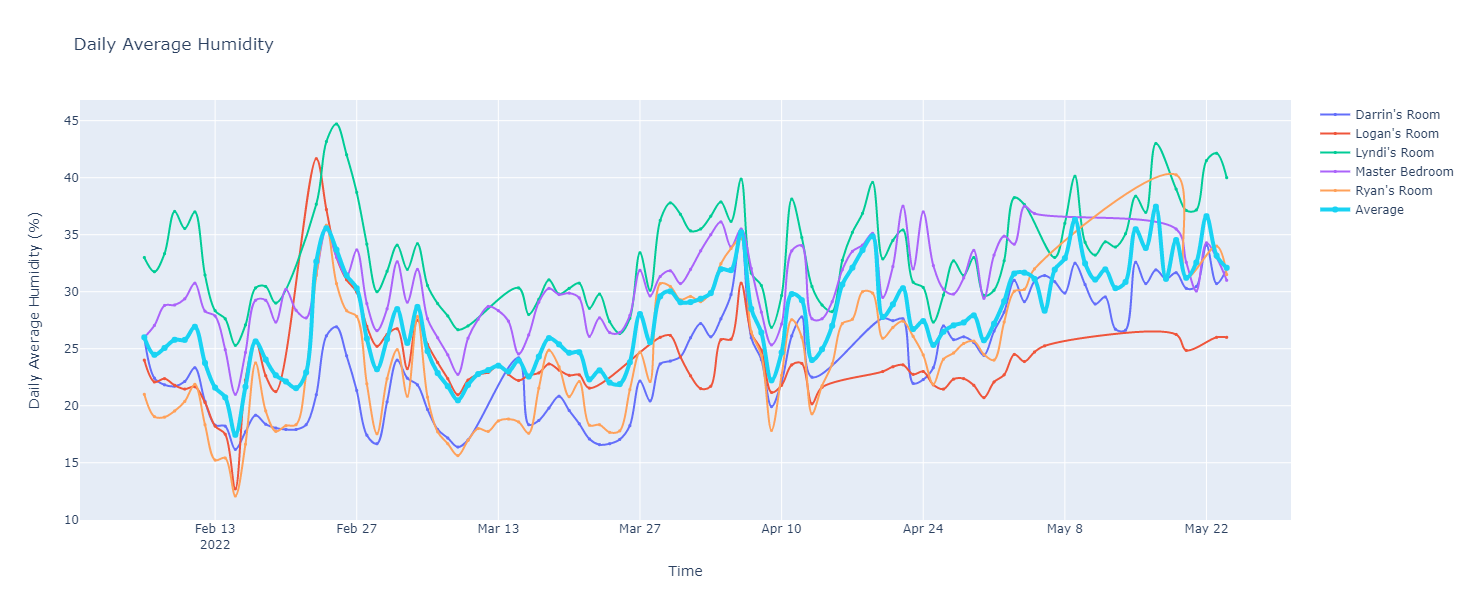

In [9]:
from plotly import graph_objects as go

plots = {}
def create_plot(plot_name, units):
    plots[plot_name] = go.Figure()
    plots[plot_name].update_layout(title=plot_name, xaxis_title="Time", yaxis_title=f"{plot_name} {units}", height=600)
    
def create_trace(room, x, y):
    isNotRoom = (room == "Weather" or room == "Average")
    room_name = (room if isNotRoom else f"{room} Bedroom" if room == "Master" else f"{room}'s Room")
    return go.Scatter(x=x, y=y, mode="lines+markers", text=room_name, name=room_name, line_shape="spline", line_width=(4 if isNotRoom else 2), marker_size=(6 if isNotRoom else 3))

# Create plots
create_plot("Daily Average Temperature", "\N{DEGREE SIGN}F")
create_plot("Daily Average Humidity", "(%)")

# Add traces to plots
for index,data in df_pivot.items():
    observation_name = "Daily Average " + ("Temperature" if index[0] == "Temperature_F" else index[0])
    room = index[1]
    data.dropna(inplace=True)
    plots[observation_name].add_trace(create_trace(room, data.index, data.values))

# Add aggregated daily average data
plots["Daily Average Temperature"].add_trace(create_trace("Average", temp_avg.index, temp_avg.values))
plots["Daily Average Humidity"].add_trace(create_trace("Average", humidity_avg.index, humidity_avg.values))
# Add local weather data
plots["Daily Average Temperature"].add_trace(create_trace("Weather", df_weather_data["Date"].values, df_weather_data["AvgTemp"].values))

# Display plots
for plot in plots:
    plots[plot].show()